##### data pull

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
turnover_trend = pd.read_csv("../data/10yr_turnover.csv")
print(turnover_trend.columns.tolist())
turnover_trend.head(3)

In [4]:
def preprocess_turnover_data(turnover_trend):
    turnover_trend['year'] = pd.to_datetime(turnover_trend['recorddate_key']).dt.to_period('Y')

    turnover_trend.columns = [col.lower() for col in turnover_trend.columns]
    # get dummies for all categoricals, drop originals
    categorical_features = ['job_title', 'gender_short', 'termreason_desc', 'termtype_desc', 'business_unit',  'department_name']
    turnover_trend = pd.get_dummies(turnover_trend, columns=categorical_features, drop_first=False)
    turnover_trend.columns = [col.lower() for col in turnover_trend.columns]

    # 1 = voluntary turnover, 0 = stayed
    turnover_trend['voluntary_turnover'] = (turnover_trend['termreason_desc_resignaton'] == True).astype(int)

    # drop any unnecessary columns
    i=0
    drop_cols = ['termreason_desc_layoff',
                'termreason_desc_not applicable',
                'termreason_desc_resignaton',
                'termreason_desc_retirement',
                'termtype_desc_involuntary',
                'termtype_desc_not applicable',
                'termtype_desc_voluntary']

    for each in turnover_trend.dtypes:
        if each == 'object':
            drop_cols.append(turnover_trend.columns[i])
        i+=1

    # remove potential model by columns from drop_cols
    model_by_cols = ['city_name', 'store_name']
    drop_cols = [col for col in drop_cols if col not in model_by_cols]
    turnover_trend.drop(columns=drop_cols+['employeeid','status_year'], inplace=True)
    
    return turnover_trend

def yearify_features(df):
    """Convert features to yearly averages or sums as appropriate."""
    df = df.copy()
    df.drop(columns=['city_name', 'store_name'], inplace=True)
    df = df.groupby('year').mean(numeric_only=False)
    return df

def city_store_yearify(df):
    """Convert features to yearly averages or sums as appropriate."""
    df = df.copy()
    df = df.groupby(['year', 'city_name', 'store_name']).mean(numeric_only=False)
    return df

In [5]:
preprocessed_turnover_trend = preprocess_turnover_data(turnover_trend)
year_df = yearify_features(preprocessed_turnover_trend)
city_store_yr_df = city_store_yearify(preprocessed_turnover_trend)

#### samples

In [6]:
preprocessed_turnover_trend.head(3) 

,age,length_of_service,city_name,store_name,year,job_title_accounting clerk,job_title_accounts payable clerk,job_title_accounts receiveable clerk,job_title_auditor,job_title_baker,...,department_name_investment,department_name_labor relations,department_name_legal,department_name_meats,department_name_processed foods,department_name_produce,department_name_recruitment,department_name_store management,department_name_training,voluntary_turnover
0,52,17,Vancouver,35,2006,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,53,18,Vancouver,35,2007,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,54,19,Vancouver,35,2008,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [7]:
year_df.head(3)

,age,length_of_service,job_title_accounting clerk,job_title_accounts payable clerk,job_title_accounts receiveable clerk,job_title_auditor,job_title_baker,job_title_bakery manager,job_title_benefits admin,job_title_ceo,...,department_name_investment,department_name_labor relations,department_name_legal,department_name_meats,department_name_processed foods,department_name_produce,department_name_recruitment,department_name_store management,department_name_training,voluntary_turnover
year,,,,,,,,,,,,,,,,,,,,,
2006,43.749727,8.262066,0.001092,0.000655,0.000874,0.000655,0.178205,0.007207,0.001092,0.000218,...,0.000874,0.001310,0.000655,0.259445,0.074470,0.223848,0.001965,0.007644,0.001092,0.002621
2007,43.270767,8.730942,0.001068,0.000641,0.000854,0.000641,0.174674,0.007047,0.001068,0.000214,...,0.000854,0.001281,0.000641,0.241512,0.087551,0.208840,0.001922,0.007474,0.001068,0.005338
2008,42.669184,9.158800,0.001049,0.000629,0.000839,0.000629,0.171387,0.006923,0.001049,0.000210,...,0.000839,0.001259,0.000629,0.229285,0.105307,0.192993,0.001888,0.007342,0.001049,0.005454


In [8]:
city_store_yr_df.head(3)

age  length_of_service  \
year city_name   store_name                                 
2006 Abbotsford  1           43.833333           7.833333   
     Aldergrove  2           44.444444           8.355556   
     Bella Bella 3           39.916667           6.833333   

                             job_title_accounting clerk  \
year city_name   store_name                               
2006 Abbotsford  1                                  0.0   
     Aldergrove  2                                  0.0   
     Bella Bella 3                                  0.0   

                             job_title_accounts payable clerk  \
year city_name   store_name                                     
2006 Abbotsford  1                                        0.0   
     Aldergrove  2                                        0.0   
     Bella Bella 3                                        0.0   

                             job_title_accounts receiveable clerk  \
year city_name   store_name                                         
2006 Abbotsford  1                                            0.0   
     Aldergrove  2                                            0.0   
     Bella Bella 3                                            0.0   

                             job_title_auditor  job_title_baker  \
year city_name   store_name                                       
2006 Abbotsford  1                         0.0         0.183333   
     Aldergrove  2                         0.0         0.244444   
     Bella Bella 3                         0.0         0.166667   

                             job_title_bakery manager  \
year city_name   store_name                             
2006 Abbotsford  1                           0.016667   
     Aldergrove  2                           0.000000   
     Bella Bella 3                           0.000000   

                             job_title_benefits admin  job_title_ceo  ...  \
year city_name   store_name                                           ...   
2006 Abbotsford  1                                0.0            0.0  ...   
     Aldergrove  2                                0.0            0.0  ...   
     Bella Bella 3                                0.0            0.0  ...   

                             department_name_investment  \
year city_name   store_name                               
2006 Abbotsford  1                                  0.0   
     Aldergrove  2                                  0.0   
     Bella Bella 3                                  0.0   

                             department_name_labor relations  \
year city_name   store_name                                    
2006 Abbotsford  1                                       0.0   
     Aldergrove  2                                       0.0   
     Bella Bella 3                                       0.0   

                             department_name_legal  department_name_meats  \
year city_name   store_name                                                 
2006 Abbotsford  1                             0.0               0.316667   
     Aldergrove  2                             0.0               0.244444   
     Bella Bella 3                             0.0               0.166667   

                             department_name_processed foods  \
year city_name   store_name                                    
2006 Abbotsford  1                                  0.116667   
     Aldergrove  2                                  0.022222   
     Bella Bella 3                                  0.000000   

                             department_name_produce  \
year city_name   store_name                            
2006 Abbotsford  1                          0.316667   
     Aldergrove  2                          0.377778   
     Bella Bella 3                          0.166667   

                             department_name_recruitment  \
year city_name   store_name                                
2006 Abbotsford  1          

# turnover eda

#### setup

In [9]:
def plot_turnover_comparison(feature_col, feature_values, feature_labels=None, title_suffix="", preprocessed_turnover_trend=preprocessed_turnover_trend):

    if feature_labels is None:
        feature_labels = [str(val) for val in feature_values]

    # Filter data for the two groups
    group1_data = preprocessed_turnover_trend[preprocessed_turnover_trend[feature_col] == feature_values[0]]

    if len(feature_values) != 2:
        group2_data = preprocessed_turnover_trend[preprocessed_turnover_trend[feature_col] != feature_values[0]]
    else:
        group2_data = preprocessed_turnover_trend[preprocessed_turnover_trend[feature_col] == feature_values[1]]
    
    # Calculate turnover rates by year for each group
    group1_turnover_by_year = group1_data.groupby('year')['voluntary_turnover'].mean()
    if len(feature_values) != 2:
        group2_turnover_by_year = group2_data.groupby('year')['voluntary_turnover'].mean()
    else:
        group2_turnover_by_year = group2_data.groupby('year')['voluntary_turnover'].mean()
    
    # Create the plot
    plt.figure(figsize=(5, 4))
    group1_turnover_by_year.plot(kind='line', marker='o', label=feature_labels[0], linewidth=2)
    group2_turnover_by_year.plot(kind='line', marker='s', label=feature_labels[1], linewidth=2)
    
    plt.title(f'Voluntary Turnover Rate by Year: {feature_labels[0]} vs {feature_labels[1]}{title_suffix}')
    plt.xlabel('Year')
    plt.ylabel('Voluntary Turnover Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"{feature_labels[0]} Average Turnover Rate:", group1_turnover_by_year.mean())
    print(f"{feature_labels[1]} Average Turnover Rate:", group2_turnover_by_year.mean())
    
def plot_turnover_by_yr(turnover_trend):
    monthly_turnover_by_reason = turnover_trend.groupby(['year', 'termreason_desc']).size().unstack(fill_value=0)
    total_workforce_by_year = turnover_trend.groupby('year').size()
    monthly_turnover_pct_by_reason = (monthly_turnover_by_reason.div(total_workforce_by_year, axis=0) * 100)
    monthly_turnover_pct_by_reason.drop(columns=['Not Applicable'], inplace=True)

    # Create the plot
    plt.figure(figsize=(5, 4))
    for reason in monthly_turnover_pct_by_reason.columns:
        monthly_turnover_pct_by_reason[reason].plot(kind='line', marker='o', label=reason)

    plt.title('Employee Turnover by Year')
    plt.xlabel('Year')
    plt.ylabel('Turnover Rate (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


### viz

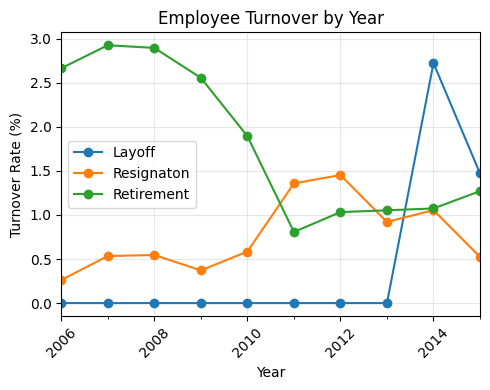

In [10]:
plot_turnover_by_yr(turnover_trend)

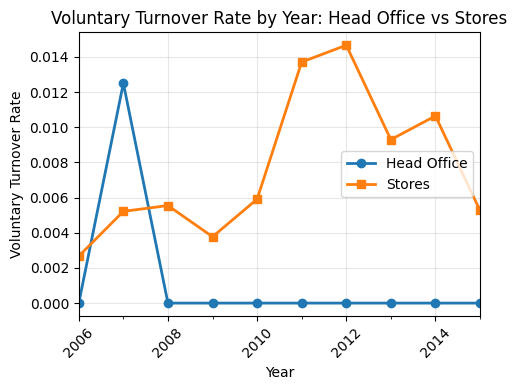

Head Office Average Turnover Rate: 0.00125
Stores Average Turnover Rate: 0.007667335559651362


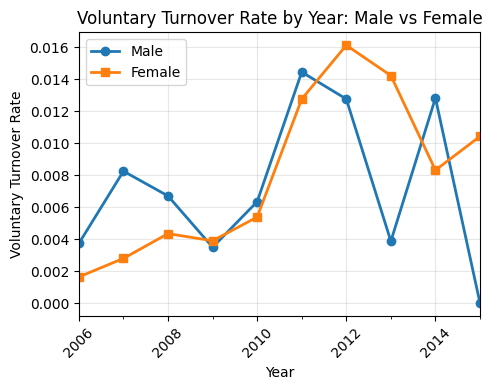

Male Average Turnover Rate: 0.007249217475824482
Female Average Turnover Rate: 0.00799795499761738


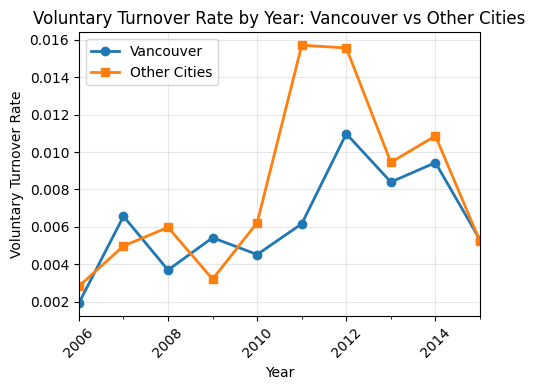

Vancouver Average Turnover Rate: 0.00623975770497936
Other Cities Average Turnover Rate: 0.0080015672512572


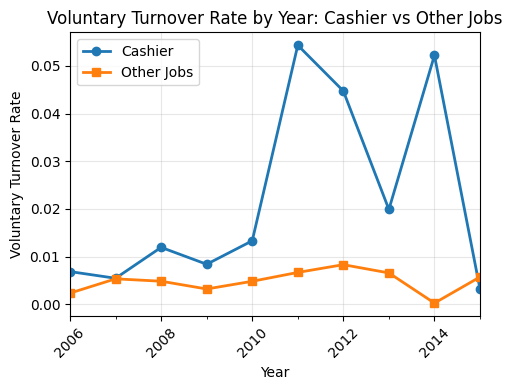

Cashier Average Turnover Rate: 0.022032175265963162
Other Jobs Average Turnover Rate: 0.004800497681320929


In [11]:
plot_turnover_comparison('business_unit_headoffice', [True, False], ['Head Office', 'Stores'])
plot_turnover_comparison('gender_short_f', [False, True], ['Male', 'Female'])
plot_turnover_comparison('city_name', ['Vancouver'], ['Vancouver', 'Other Cities'])
plot_turnover_comparison('job_title_cashier', [True, False], ['Cashier', 'Other Jobs'])

### job title

#### setup

In [12]:
turnover_trend['voluntary_turnover'] = (turnover_trend['termreason_desc']=='Resignaton')

def plot_turnover_by_job_title(turnover_trend):
    turnover_trend = turnover_trend.copy()

    # Get turnover rates by job title
    job_title_turnover = turnover_trend.groupby('job_title')['voluntary_turnover'].agg(['count', 'sum', 'mean']).reset_index()
    job_title_turnover.columns = ['job_title', 'total_employees', 'total_turnover', 'turnover_rate']
    job_title_turnover['turnover_rate'] = job_title_turnover['turnover_rate'] * 100

    # Sort by turnover rate and filter for job titles with reasonable sample sizes
    job_title_turnover = (job_title_turnover[(job_title_turnover['turnover_rate'] >= 0.01) &
                                            (job_title_turnover['total_employees'] >= 10)])
    job_title_turnover = job_title_turnover.sort_values('turnover_rate', ascending=True)

    # Create the plot
    plt.figure(figsize=(5, 4))
    plt.barh(job_title_turnover['job_title'], job_title_turnover['turnover_rate'])
    plt.xlabel('Voluntary Turnover Rate')
    plt.ylabel('Job Title')
    plt.title('Voluntary Turnover Rate by Job Title (Min 10 employees)')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

    # Display the data
    print("Top 10 Job Titles by Turnover Rate:")
    print(job_title_turnover.head(10)[['job_title', 'turnover_rate', 'total_employees']])

    return job_title_turnover.head(10)['job_title'].tolist()

def plot_turnover_trend_by_top_job_titles(turnover_trend, top_10):
    turnover_trend = turnover_trend.copy()
    # Create a pivot table for turnover by year and job title
    turnover_by_year_job = turnover_trend.groupby(['year', 'job_title'])['voluntary_turnover'].mean().unstack(fill_value=0)

    # Filter for job titles with significant turnover rates
    turnover_subset = turnover_by_year_job[top_10]
    turnover_subset = turnover_subset * 100 

    # Get total sample sizes for each job title
    job_title_counts = turnover_trend['job_title'].value_counts()

    # Create the plot
    plt.figure(figsize=(8, 4))
    for job_title in top_10:
        sample_size = job_title_counts[job_title]
        label = f"{job_title} (n={sample_size})"
        turnover_subset[job_title].plot(kind='line', marker='o', label=label, linewidth=2)

    plt.title('Voluntary Turnover Rate by Year and Job Title')
    plt.xlabel('Year')
    plt.ylabel('Voluntary Turnover Rate')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Display summary statistics
    print("Average turnover rates by job title:")
    for job_title in top_10:
        avg_rate = turnover_subset[job_title].mean()
        print(f"{job_title}: {avg_rate:.4f}")

### viz

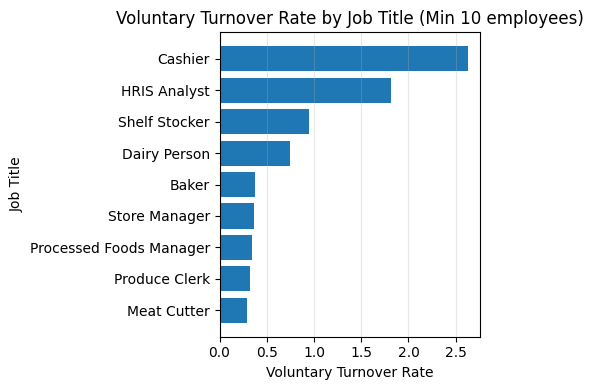

Top 10 Job Titles by Turnover Rate:
                  job_title  turnover_rate  total_employees
34              Meat Cutter       0.290465             9984
37            Produce Clerk       0.327789             8237
36  Processed Foods Manager       0.346021              289
41            Store Manager       0.369004              271
4                     Baker       0.370553             8096
14             Dairy Person       0.745052             8590
40            Shelf Stocker       0.942725             5622
30             HRIS Analyst       1.818182               55
9                   Cashier       2.626174             6816


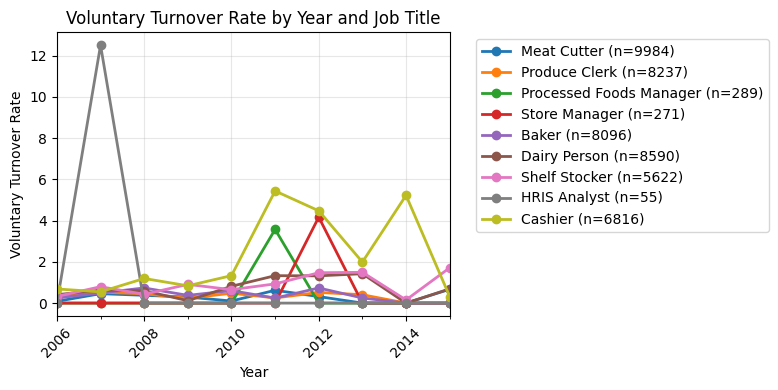

Average turnover rates by job title:
Meat Cutter: 0.2921
Produce Clerk: 0.3169
Processed Foods Manager: 0.3571
Store Manager: 0.4167
Baker: 0.3672
Dairy Person: 0.7324
Shelf Stocker: 0.8856
HRIS Analyst: 1.2500
Cashier: 2.2032


In [13]:
top_10 = plot_turnover_by_job_title(turnover_trend)
plot_turnover_trend_by_top_job_titles(turnover_trend, top_10)


# economic data

In [14]:
econ_df = pd.read_excel("../data/economic_data.xlsx", sheet_name="annual_data")
econ_df['year'] = pd.to_datetime(econ_df['year'], format='%Y').dt.to_period('Y')
econ_df.head(3)

,year,avg_hire_rt,avg_openings_rt,med_wkly_rl_earn_82_84_cpi_usd
0,2006,3.950000,3.250000,333
1,2007,3.858333,3.291667,335
2,2008,3.433333,2.691667,335


In [15]:
year_df = year_df.reset_index()
year_df.head(3)

,year,age,length_of_service,job_title_accounting clerk,job_title_accounts payable clerk,job_title_accounts receiveable clerk,job_title_auditor,job_title_baker,job_title_bakery manager,job_title_benefits admin,...,department_name_investment,department_name_labor relations,department_name_legal,department_name_meats,department_name_processed foods,department_name_produce,department_name_recruitment,department_name_store management,department_name_training,voluntary_turnover
0,2006,43.749727,8.262066,0.001092,0.000655,0.000874,0.000655,0.178205,0.007207,0.001092,...,0.000874,0.001310,0.000655,0.259445,0.074470,0.223848,0.001965,0.007644,0.001092,0.002621
1,2007,43.270767,8.730942,0.001068,0.000641,0.000854,0.000641,0.174674,0.007047,0.001068,...,0.000854,0.001281,0.000641,0.241512,0.087551,0.208840,0.001922,0.007474,0.001068,0.005338
2,2008,42.669184,9.158800,0.001049,0.000629,0.000839,0.000629,0.171387,0.006923,0.001049,...,0.000839,0.001259,0.000629,0.229285,0.105307,0.192993,0.001888,0.007342,0.001049,0.005454


In [16]:
merged_df = pd.merge(year_df, econ_df, on='year', how='inner')
merged_df.head(3)

,year,age,length_of_service,job_title_accounting clerk,job_title_accounts payable clerk,job_title_accounts receiveable clerk,job_title_auditor,job_title_baker,job_title_bakery manager,job_title_benefits admin,...,department_name_meats,department_name_processed foods,department_name_produce,department_name_recruitment,department_name_store management,department_name_training,voluntary_turnover,avg_hire_rt,avg_openings_rt,med_wkly_rl_earn_82_84_cpi_usd
0,2006,43.749727,8.262066,0.001092,0.000655,0.000874,0.000655,0.178205,0.007207,0.001092,...,0.259445,0.074470,0.223848,0.001965,0.007644,0.001092,0.002621,3.950000,3.250000,333
1,2007,43.270767,8.730942,0.001068,0.000641,0.000854,0.000641,0.174674,0.007047,0.001068,...,0.241512,0.087551,0.208840,0.001922,0.007474,0.001068,0.005338,3.858333,3.291667,335
2,2008,42.669184,9.158800,0.001049,0.000629,0.000839,0.000629,0.171387,0.006923,0.001049,...,0.229285,0.105307,0.192993,0.001888,0.007342,0.001049,0.005454,3.433333,2.691667,335


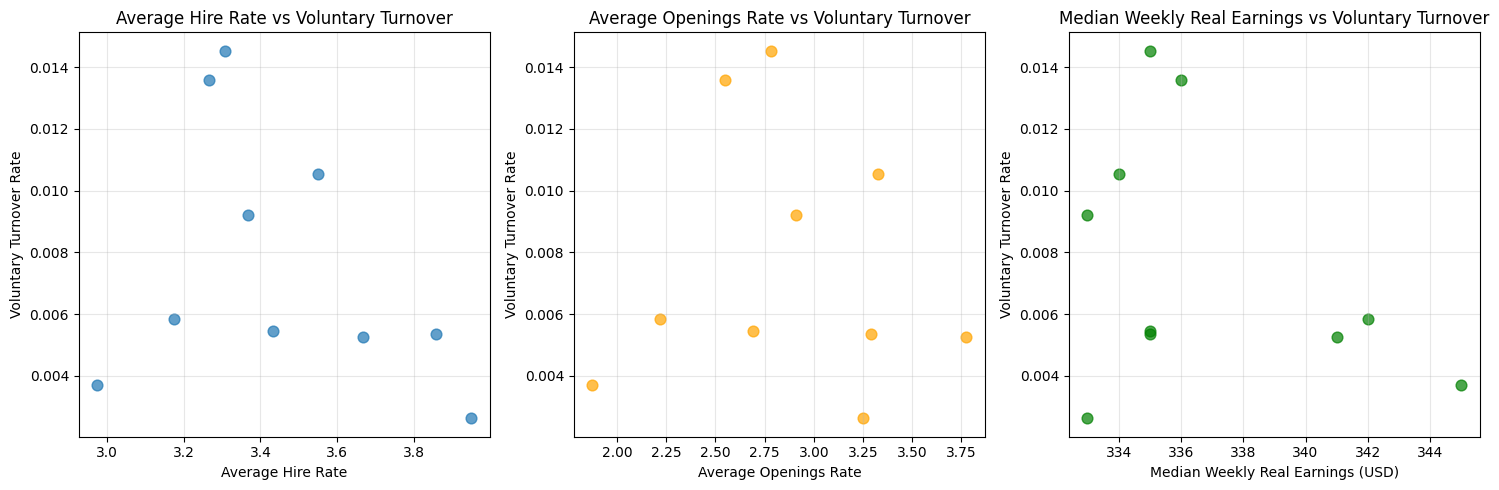

Correlation between economic indicators and voluntary turnover:
Average Hire Rate: -0.3070
Average Openings Rate: -0.0327
Median Weekly Real Earnings: -0.3570


In [17]:
# Create scatter plots showing the relationship between economic indicators and voluntary turnover
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Average Hire Rate vs Voluntary Turnover
axes[0].scatter(merged_df['avg_hire_rt'], merged_df['voluntary_turnover'], alpha=0.7, s=60)
axes[0].set_xlabel('Average Hire Rate')
axes[0].set_ylabel('Voluntary Turnover Rate')
axes[0].set_title('Average Hire Rate vs Voluntary Turnover')
axes[0].grid(True, alpha=0.3)

# Plot 2: Average Openings Rate vs Voluntary Turnover
axes[1].scatter(merged_df['avg_openings_rt'], merged_df['voluntary_turnover'], alpha=0.7, s=60, color='orange')
axes[1].set_xlabel('Average Openings Rate')
axes[1].set_ylabel('Voluntary Turnover Rate')
axes[1].set_title('Average Openings Rate vs Voluntary Turnover')
axes[1].grid(True, alpha=0.3)

# Plot 3: Median Weekly Real Earnings vs Voluntary Turnover
axes[2].scatter(merged_df['med_wkly_rl_earn_82_84_cpi_usd'], merged_df['voluntary_turnover'], alpha=0.7, s=60, color='green')
axes[2].set_xlabel('Median Weekly Real Earnings (USD)')
axes[2].set_ylabel('Voluntary Turnover Rate')
axes[2].set_title('Median Weekly Real Earnings vs Voluntary Turnover')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlation coefficients
print("Correlation between economic indicators and voluntary turnover:")
print(f"Average Hire Rate: {merged_df['avg_hire_rt'].corr(merged_df['voluntary_turnover']):.4f}")
print(f"Average Openings Rate: {merged_df['avg_openings_rt'].corr(merged_df['voluntary_turnover']):.4f}")
print(f"Median Weekly Real Earnings: {merged_df['med_wkly_rl_earn_82_84_cpi_usd'].corr(merged_df['voluntary_turnover']):.4f}")

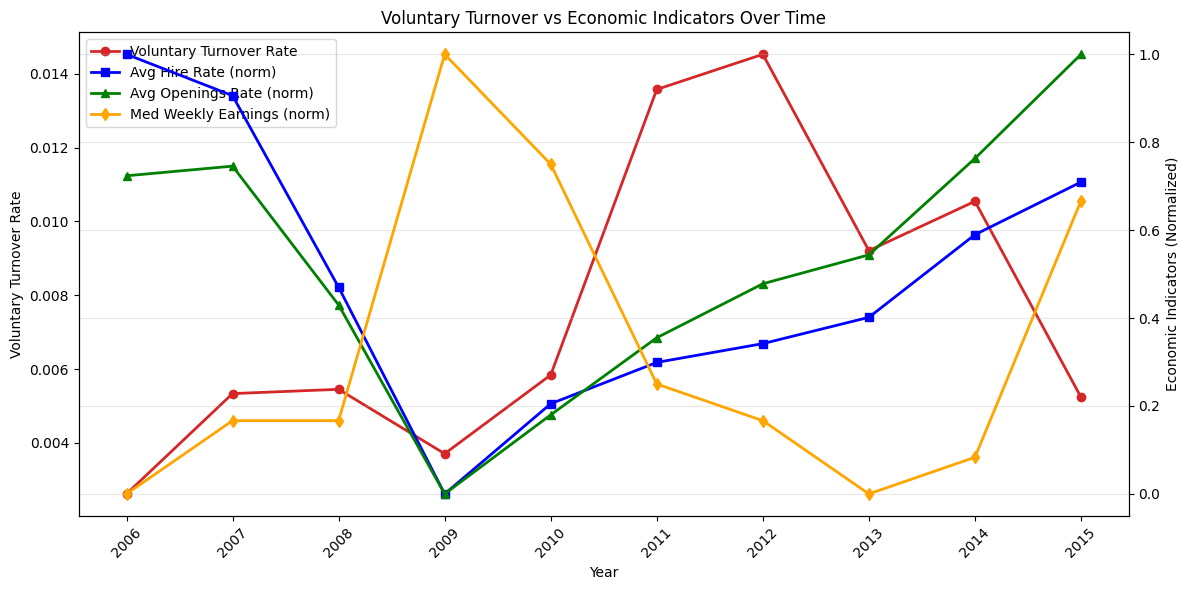

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Create a combined plot showing turnover vs economic indicators on the same timeline
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot voluntary turnover on primary y-axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Voluntary Turnover Rate')
line1 = ax1.plot(merged_df['year'].astype(str), merged_df['voluntary_turnover'], 
                 marker='o', linewidth=2, color=color, label='Voluntary Turnover Rate')
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', rotation=45)

# Create secondary y-axis for economic indicators
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Economic Indicators (Normalized)')

# Normalize economic indicators to 0-1 scale for comparison
scaler = MinMaxScaler()
econ_indicators = ['avg_hire_rt', 'avg_openings_rt', 'med_wkly_rl_earn_82_84_cpi_usd']
normalized_data = scaler.fit_transform(merged_df[econ_indicators])

line2 = ax2.plot(merged_df['year'].astype(str), normalized_data[:, 0], 
                 marker='s', linewidth=2, color='blue', label='Avg Hire Rate (norm)')
line3 = ax2.plot(merged_df['year'].astype(str), normalized_data[:, 1], 
                 marker='^', linewidth=2, color='green', label='Avg Openings Rate (norm)')
line4 = ax2.plot(merged_df['year'].astype(str), normalized_data[:, 2], 
                 marker='d', linewidth=2, color='orange', label='Med Weekly Earnings (norm)')

ax2.tick_params(axis='y')

# Add legend
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Voluntary Turnover vs Economic Indicators Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
print(f"Average Hire Rate: {pd.Series(normalized_data[:, 0]).corr(merged_df['voluntary_turnover']):.4f}")
print(f"Average Openings Rate: {pd.Series(normalized_data[:, 1]).corr(merged_df['voluntary_turnover']):.4f}")
print(f"Median Weekly Real Earnings: {pd.Series(normalized_data[:, 2]).corr(merged_df['voluntary_turnover']):.4f}")

Average Hire Rate: -0.3070
Average Openings Rate: -0.0327
Median Weekly Real Earnings: -0.3570


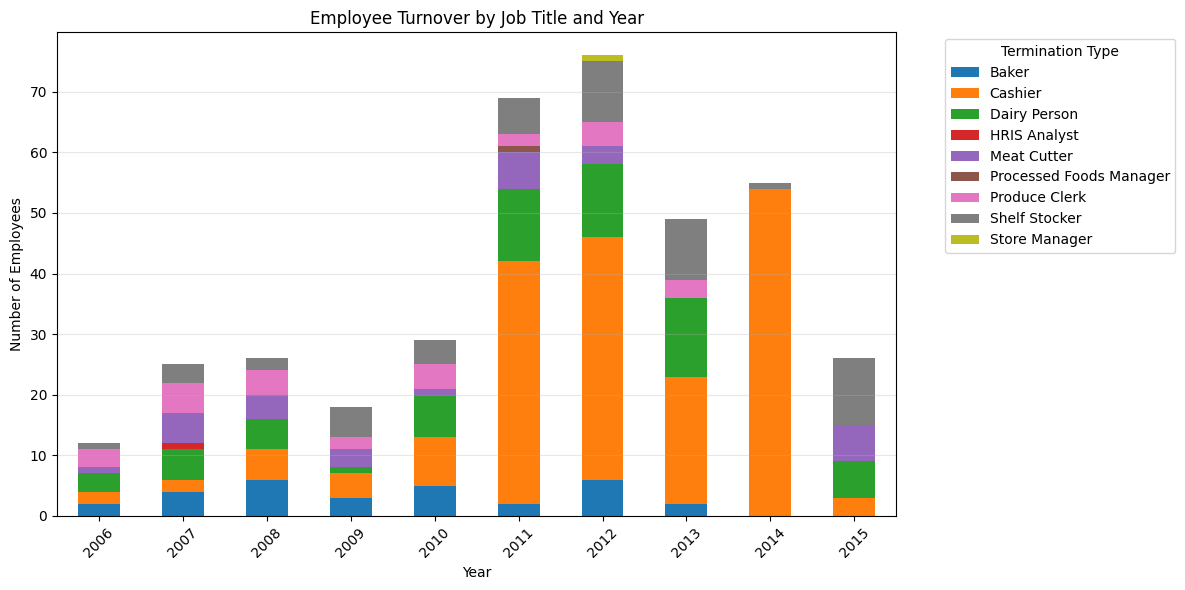

In [20]:
turnover_by_year_type = turnover_trend[turnover_trend['termreason_desc'] == 'Resignaton'].groupby(['year', 'job_title']).size().unstack(fill_value=0)

# Create the plot
plt.figure(figsize=(12, 6))
turnover_by_year_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Employee Turnover by Job Title and Year')
plt.xlabel('Year')
plt.ylabel('Number of Employees')
plt.legend(title='Termination Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

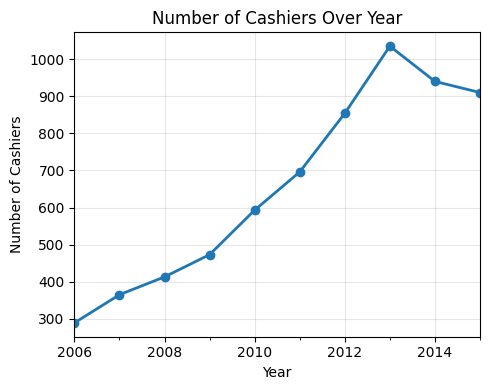

In [21]:
# plot number of cashiers over year
turnover_by_job_title = turnover_trend[(turnover_trend['job_title'] == 'Cashier') & (turnover_trend['termtype_desc'] == 'Not Applicable')].groupby('year').size()
plt.figure(figsize=(5, 4))
turnover_by_job_title.plot(kind='line', marker='o', linewidth=2)
plt.title('Number of Cashiers Over Year')
plt.xlabel('Year')
plt.ylabel('Number of Cashiers')
plt.grid(True, alpha=0.3)
plt.tight_layout()


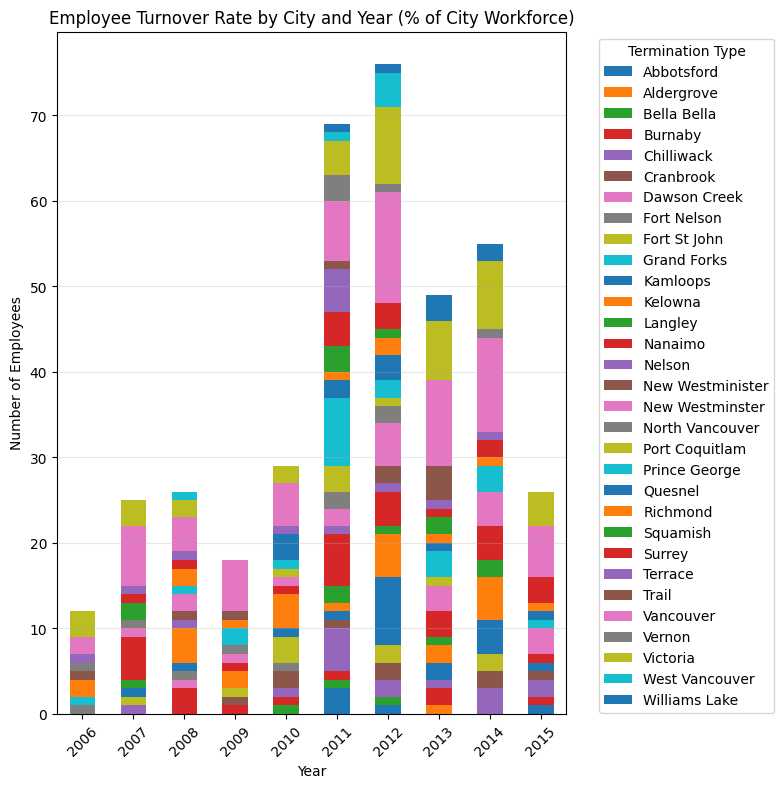

In [22]:
turnover_by_year_type = turnover_trend[turnover_trend['termreason_desc'] == 'Resignaton'].groupby(['year', 'city_name']).size().unstack(fill_value=0)

# Create the plot
plt.figure(figsize=(8, 8))
turnover_by_year_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Employee Turnover Rate by City and Year (% of City Workforce)')
plt.xlabel('Year')
plt.ylabel('Number of Employees')
plt.legend(title='Termination Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

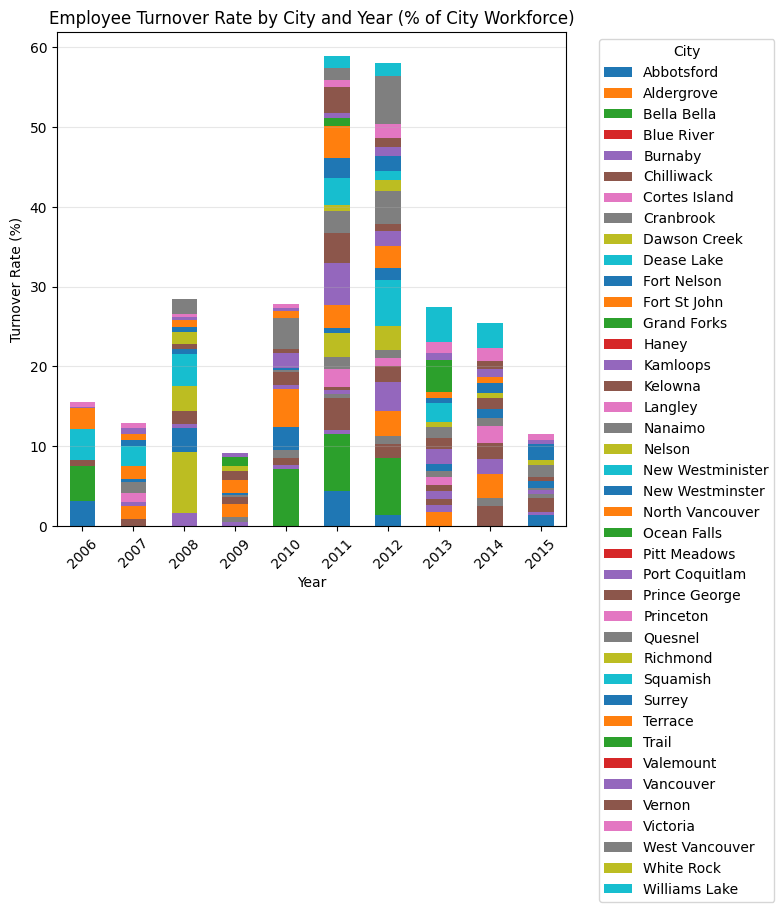

In [23]:
# Get total workforce by city and year (all employees, not just resignations)
total_workforce_by_city_year = turnover_trend.groupby(['year', 'city_name']).size()

# Get resignations by city and year
resignations_by_city_year = turnover_trend[turnover_trend['termreason_desc'] == 'Resignaton'].groupby(['year', 'city_name']).size()

# Calculate turnover rate as percentage of total workforce
turnover_rate_by_city_year = (resignations_by_city_year / total_workforce_by_city_year * 100).fillna(0)

# Pivot to get cities as columns
turnover_by_year_type = turnover_rate_by_city_year.unstack(fill_value=0)

# Create the plot
plt.figure(figsize=(8, 8))
turnover_by_year_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Employee Turnover Rate by City and Year (% of City Workforce)')
plt.xlabel('Year')
plt.ylabel('Turnover Rate (%)')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

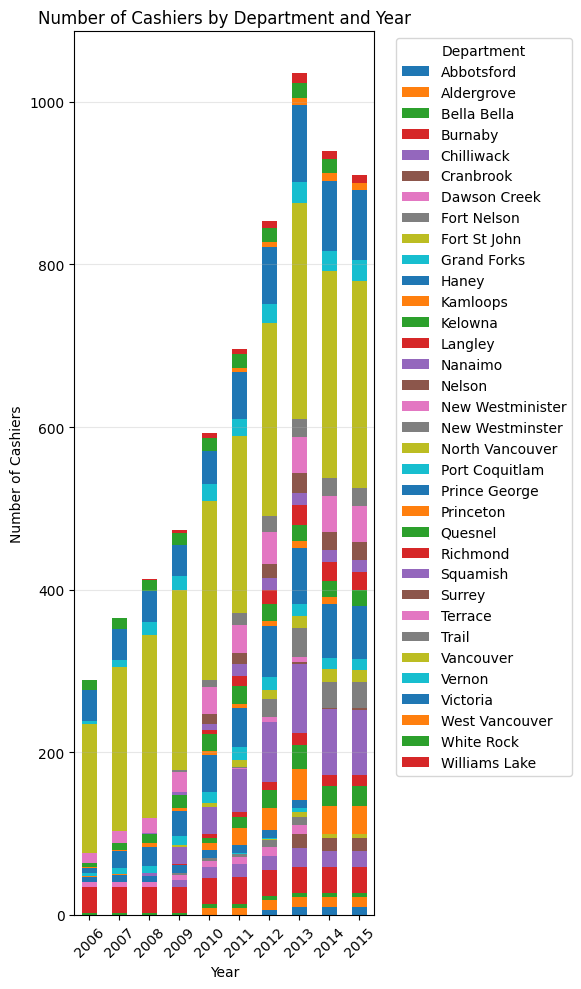

In [24]:
# now plot stacked bar of just cashiers colored by department_name by year

turnover_by_dept = turnover_trend[(turnover_trend['job_title'] == 'Cashier') & (turnover_trend['termtype_desc'] == 'Not Applicable')].groupby(['year', 'city_name']).size().unstack(fill_value=0)
plt.figure(figsize=(6, 10))
turnover_by_dept.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Number of Cashiers by Department and Year')
plt.xlabel('Year')
plt.ylabel('Number of Cashiers')
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

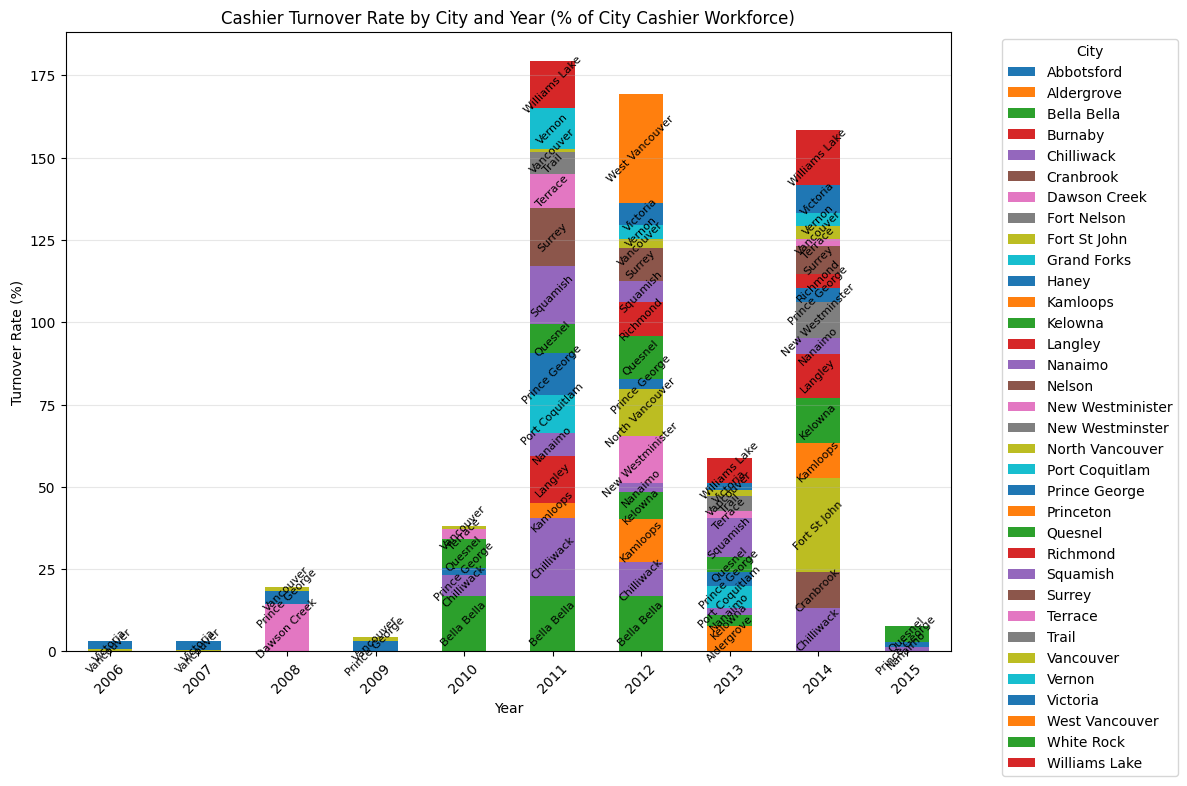

In [34]:
cashier_df = preprocessed_turnover_trend[preprocessed_turnover_trend['job_title_cashier'] == True]
# plot turnover by city and year for cashiers only
cashier_resignations = cashier_df[cashier_df['voluntary_turnover'] == 1].groupby(['year', 'city_name']).size()
total_cashiers_by_city_year = cashier_df.groupby(['year', 'city_name']).size()

# Calculate turnover rate as percentage
turnover_rate_by_city_year = (cashier_resignations / total_cashiers_by_city_year * 100).fillna(0)
turnover_by_year_type = turnover_rate_by_city_year.unstack(fill_value=0)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
bars = turnover_by_year_type.plot(kind='bar', stacked=True, ax=ax)

# Add city name labels on bars where values > 0
for i, container in enumerate(ax.containers):
    city_name = turnover_by_year_type.columns[i]
    # Only add labels where the bar height is greater than 0
    labels = [city_name if v > 0 else '' for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8, rotation=45)

plt.title('Cashier Turnover Rate by City and Year (% of City Cashier Workforce)')
plt.xlabel('Year')
plt.ylabel('Turnover Rate (%)')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()